In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

from glob import glob

import sys
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


In [2]:


def _weight_variable(shape, name='W'):
    initial = tf.truncated_normal(stddev=0.1, shape=shape)
    #return tf.get_variable(name=name, initializer=initial)
    return tf.Variable(initial)

def _bias_variable(size, name='b'):
    initial = tf.constant(value=0.1, shape=[size])
    #return tf.get_variable(name=name, initializer=initial)
    return tf.Variable(initial)

def _linear(input, out_dim):

    in_dim = input.get_shape().as_list()[-1]
    mat_shape = in_dim, out_dim
    W = _weight_variable(mat_shape)

    b = _bias_variable(out_dim)

    return tf.matmul(input, W) + b

def _fully(input, width, scope_name):
    with tf.variable_scope(scope_name):
        lin = _linear(input, width)
    return tf.nn.relu(lin)

def _conv(input, K, D, scope_name):
    
    in_D = input.get_shape().as_list()[-1]
    
    with tf.variable_scope(scope_name):
        kernel = _weight_variable([K, K, in_D, D], 'K')
        bias = _bias_variable(D)
        lin = tf.nn.conv2d(input, kernel, 
                           strides=[1, 1, 1, 1], 
                           padding='SAME')
        
        return tf.nn.relu(lin+bias)
    
def _deconv(input, kernel_size, depth, scope_name, stride=2, pad=1):
    
    batch, W_in, H_in, D_in = input.get_shape().as_list()
    #print(batch, W_in, H_in, D_in)
    #print(type(batch), type(W_in), type(H_in), type(D_in))
    W = stride * (W_in - 1) + kernel_size
    H = stride * (H_in - 1) + kernel_size
    K = kernel_size
    D = depth
    #print(W, H)
    # output_shape of conv2d_transpose does not support 
    # implicit/symbolic representation of batch size: 
    # neither '-1' nor 'None' works
    # output_shape = [None, H, W, D]
    
    #Workaround
    batch = tf.shape(input)[0]
    output_shape = [batch, H, W, D]
    with tf.variable_scope(scope_name):
        kernel = _weight_variable([K, K, D, D_in], 'K')
        bias = _bias_variable(D)
        lin = tf.nn.conv2d_transpose(
            value=input, 
            filter=kernel,
            output_shape=output_shape,
            strides=[1, 2, 2, 1], 
            padding='VALID')
    
    out = tf.reshape(tf.nn.relu(lin + bias), output_shape)
    #print('out shape', out.get_shape())
    
    #print('-'*40)
    return out
    

In [3]:
z = tf.placeholder(tf.float32, [None, 100])
fc = _fully(z, 4096, 'project')
shaped = tf.reshape(fc, [-1, 2, 2, 1024])
deconv1 = _deconv(shaped, 5, 512, 'dc1')
deconv2 = _deconv(deconv1, 5, 256, 'dc2')
deconv3 = _deconv(deconv2, 5, 128, 'dc3')
G = _deconv(deconv3, 5, 3, 'dc4')

print('G shape', G.get_shape())

G shape (?, 77, 77, 3)


In [4]:
for v in tf.trainable_variables():
    print(v.name, '\t', v.get_shape())

project/Variable:0 	 (100, 4096)
project/Variable_1:0 	 (4096,)
dc1/Variable:0 	 (5, 5, 512, 1024)
dc1/Variable_1:0 	 (512,)
dc2/Variable:0 	 (5, 5, 256, 512)
dc2/Variable_1:0 	 (256,)
dc3/Variable:0 	 (5, 5, 128, 256)
dc3/Variable_1:0 	 (128,)
dc4/Variable:0 	 (5, 5, 3, 128)
dc4/Variable_1:0 	 (3,)


In [7]:

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    summary_writer = tf.train.SummaryWriter('./summary/', sess.graph)
    summary_str = sess.run(G, {z: np.random.randn(10, 100)})
    #summary_writer.add_summary(summary_str, 0)
    

(1, 77, 77, 3)


TypeError: Invalid dimensions for image data

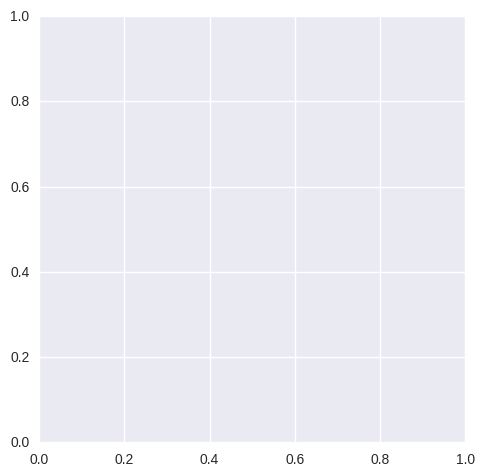

In [17]:
def plot_response():
    with tf.Session() as sess:
        z_feed = np.random.randn(1, 100)
        tf.global_variables_initializer().run()
        response = G.eval(feed_dict={z: z_feed})
        print(response.shape)
        plt.imshow(response.)
    
    return z_feed
plot_response().shape



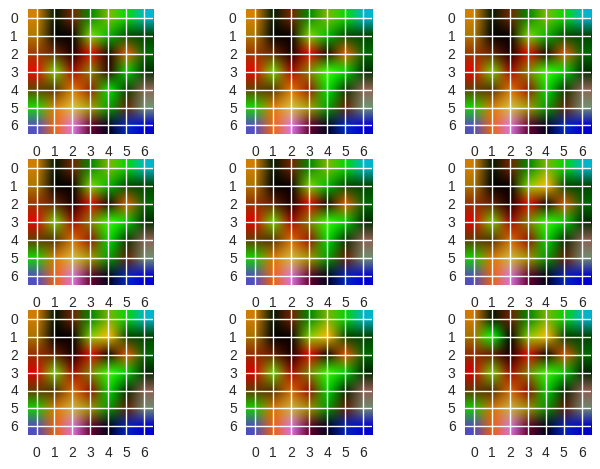

In [27]:
plot_response(-1000, -990)